# Climate Financial Risk Analysis 

## Question / Hypothesis
We aim to investigate whether multilateral climate funds are efficiently targeting the most vulnerable countries and regions. Specifically, we will analyze how financing flows vary geographically and by project types, and examine the alignment of these flows with climate vulnerability.

## Research Interests
- Climate finance and policy  
- Environmental vulnerability metrics  
- Global emissions and sustainable development
  
## Datasets
- Climate Funds Update Dashboard
- CO2 Emissions per Country (1850-2023)
- Methane Emissions per Country (1850-2023)
- Climate Finance Vulnerability Index

## Planned Analysis
We plan to perform descriptive statistics and correlation analyses to explore the relationship between climate fund allocations and vulnerability. This will include visualizing the geographic distribution of funds and comparing this with emissions and vulnerability data. Our goal is to understand which countries are contributing most to climate change and which are in most need of support.


In [34]:
# Setup 
## import package
#!pip install geoplot
#!pip install openpyxl
#!pip install pypalettes highlight-text
#!pip install basemap

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
from pypalettes import load_cmap
from highlight_text import fig_text, ax_text

## import data



## Data Processing

In [4]:
###

## Data Visualization

/tmp/ipykernel_284/2705440076.py:49: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  data_projected['centroid'] = data_projected.geometry.centroid


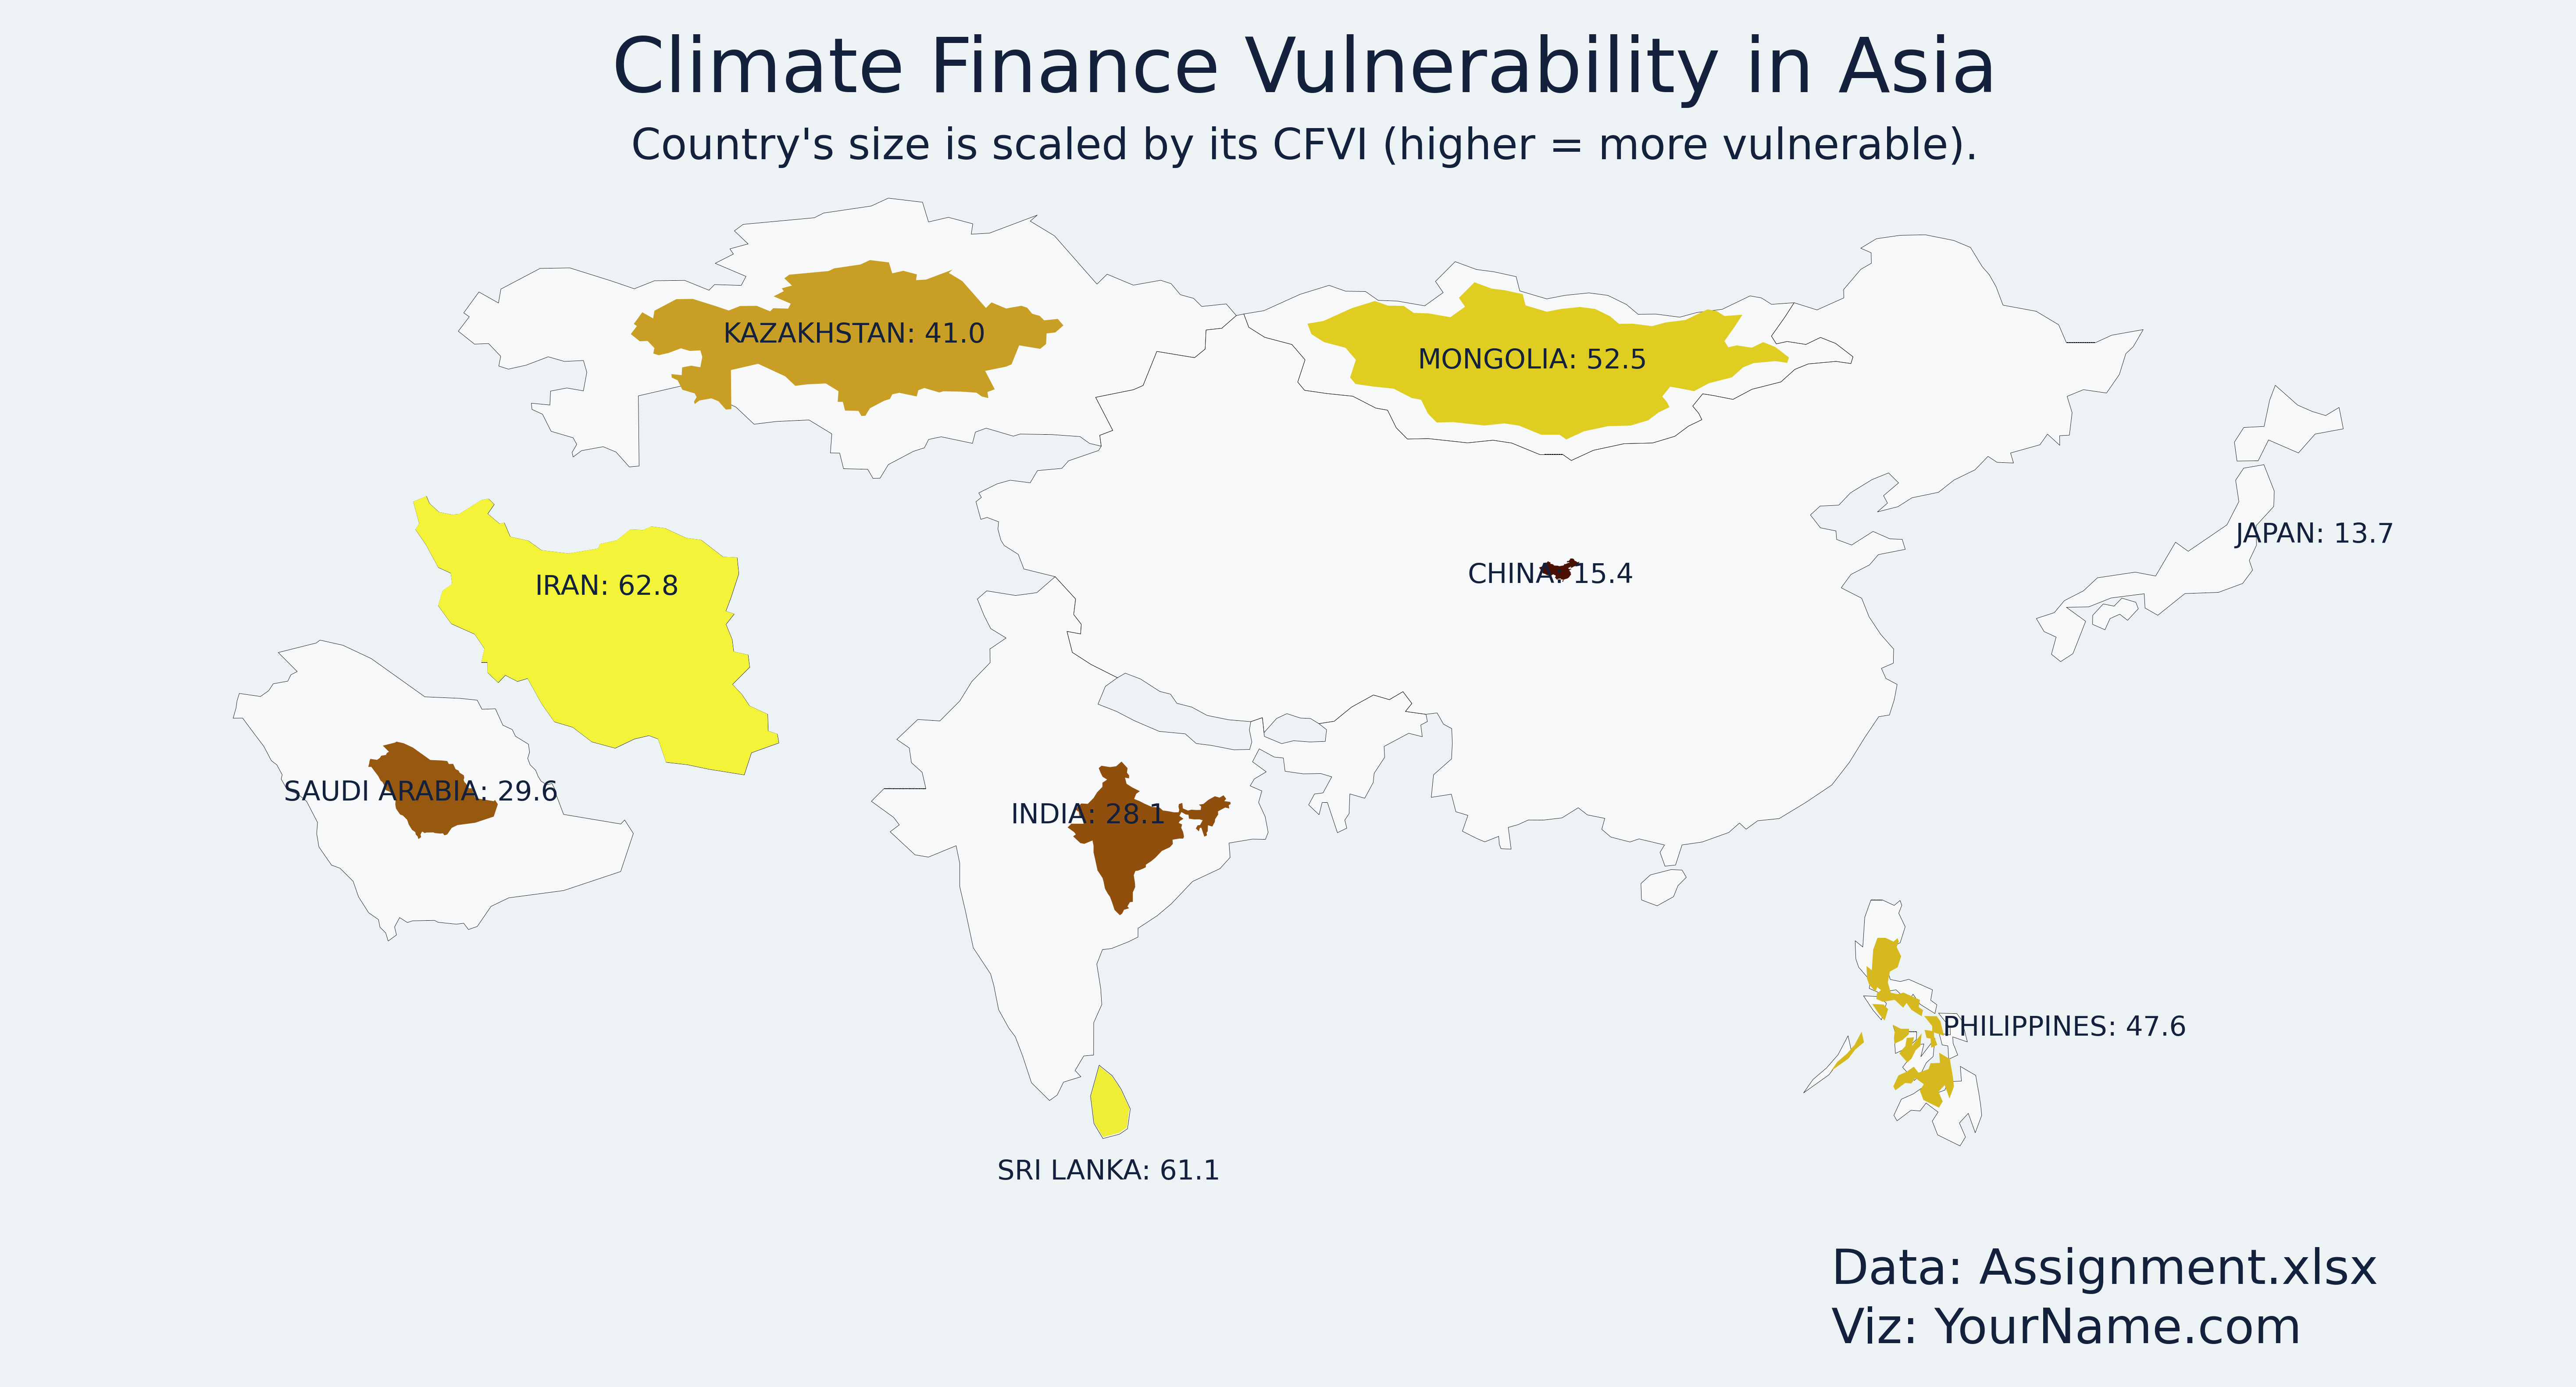

In [76]:
# Semi-Cartogram


plt.rcParams['figure.dpi'] = 500
plt.rcParams['savefig.dpi'] = 500

from matplotlib.font_manager import FontProperties
other_font = None
other_bold_font = None

# import data 

world = gpd.read_file('https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/all_world.geojson')

vuln = pd.read_csv("CFVI.csv")
vuln.columns = vuln.columns.str.strip().str.replace('`', '')

# clean up
countries = ['China', 'India', 'Japan', 'Mongolia', 'Kazakhstan', 'Turkey', 'Philippines', 'Sri Lanka', 'Saudi Arabia', 'Iran']
data = world.merge(vuln, how="right", left_on="name", right_on="Country")
data = data[data['Country'].isin(countries)]

# Normalize index
data['vulnerability_norm'] = data['Index Score'] / data['Index Score'].max()

# plot map
cmap = load_cmap("Antennarius_multiocellatus", cmap_type='continuous', reverse=False)
background_color = '#edf2f4'
text_color = '#14213d'
map_color = (1.0, 1.0, 1.0, 0.5)


fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111, projection=gcrs.PlateCarree())
fig.set_facecolor(background_color)
ax.set_facecolor(background_color)


gplt.cartogram(
    data, projection=gcrs.PlateCarree(), cmap=cmap,
    scale='vulnerability_norm', hue='vulnerability_norm', limits=(0, 1),
    ax=ax
)

gplt.polyplot(data, facecolor=map_color, edgecolor='black', linewidth=0.12, ax=ax)


data_projected = data.to_crs(epsg=4326)
data_projected['centroid'] = data_projected.geometry.centroid
data['centroid'] = data_projected['centroid'].to_crs(data.crs)

adjustments = {
    'Japan': (6, 0),
    'Philippines': (8, 0),
    'Sri Lanka': (0, -3.5),
    'Turkey': (-1, 1.2),
    'China': (0, -1),
    'Iran': (0, 2.4)
}

for country in countries:
    if country in data['Country'].values:
        centroid = data.loc[data['Country'] == country, 'centroid'].values[0]
        x, y = centroid.coords[0]
        x, y = (x + adjustments[country][0], y + adjustments[country][1]) if country in adjustments else (x, y)
        value = data.loc[data['Country'] == country, 'Index Score'].values[0]
        ax_text(
            x=x, y=y, s=f"<{country.upper()}>: {value:.1f}",
            fontsize=9, font=other_font, color=text_color,
            ha='center', va='center', ax=ax,
            highlight_textprops=[{'font': other_bold_font}]
        )



fig_text(
    x=0.5, y=0.92, s="Climate Finance Vulnerability in Asia",
    fontsize=25, ha='center', font=other_bold_font, color=text_color
)
fig_text(
    x=0.5, y=0.86,
    s="Country's size is scaled by its CFVI (higher = more vulnerable).",
    fontsize=14, ha='center', font=other_font, color=text_color
)
fig_text(
    x=0.7, y=0.13, s="<Data>: Assignment.xlsx\n<Viz>: YourName.com",
    font=other_font, fontsize=16, color=text_color,
    highlight_textprops=[{'font': other_bold_font}, {'font': other_bold_font}]
)


plt.tight_layout()
plt.show()

   Rank        Country  Index Score
0   188  Guinea-Bissau         90.9
1   187        Eritrea         89.2
2   186         Angola         87.7
3   185         Zambia         86.4
4   184      Palestine         85.8


/tmp/ipykernel_284/1421217023.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged['centroid'] = merged['geometry'].centroid


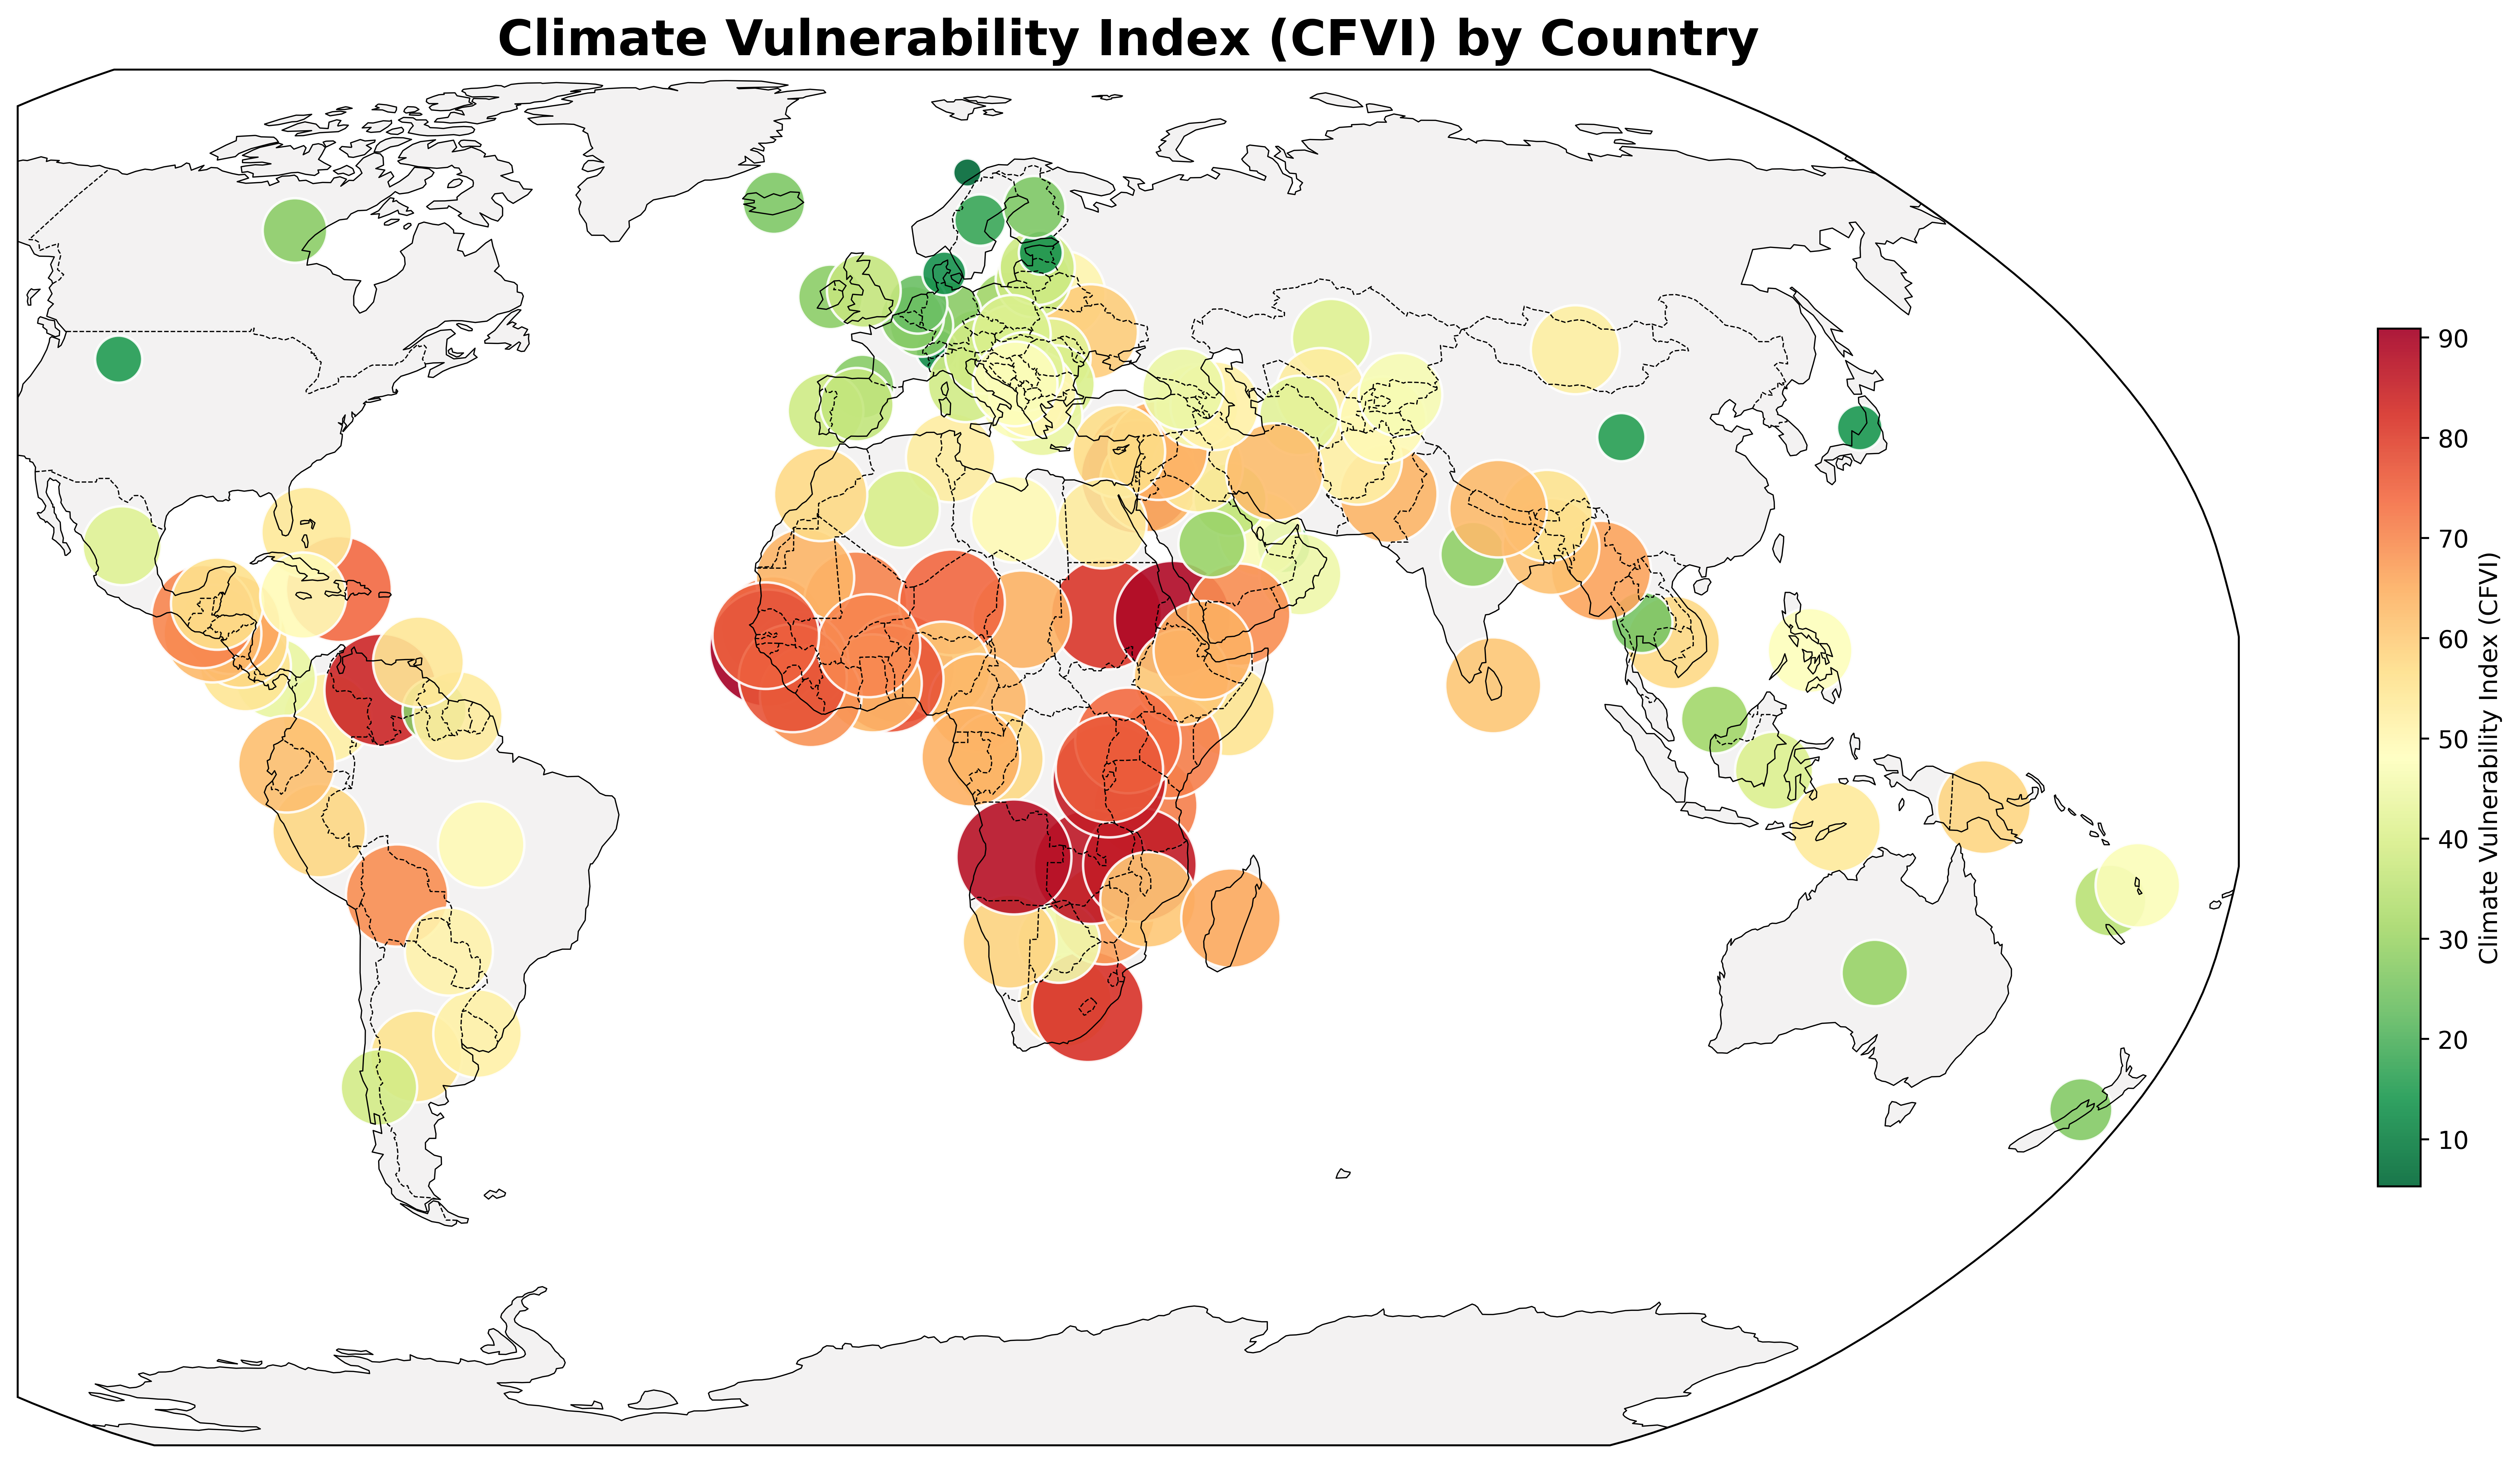

In [71]:
# bubble map model

df = pd.read_csv("CFVI.csv")  
print(df.head())  

world = gpd.read_file('https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/all_world.geojson')

merged = world.merge(df, left_on='name', right_on='Country', how='left')

# Calculate centroids
merged['centroid'] = merged['geometry'].centroid
merged['x'] = merged['centroid'].x
merged['y'] = merged['centroid'].y


plt.figure(figsize=(16, 10))
ax = plt.axes(projection=ccrs.Robinson())

ax.add_feature(cfeature.LAND, facecolor='#F3F2F2')  # Light grey land
ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle='--')
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)

# Bubble plot
scatter = ax.scatter(
    merged['x'], merged['y'],
    s=merged['Index Score'] * 25,
    c=merged['Index Score'],
    cmap='RdYlGn_r',
    alpha=0.9,
    edgecolor='white',
    transform=ccrs.PlateCarree()
)

plt.colorbar(scatter, ax=ax, orientation='vertical', shrink=0.5, pad=0.05).set_label('Climate Vulnerability Index (CFVI)')

plt.title('Climate Vulnerability Index (CFVI) by Country',
          fontweight='bold', fontsize=20)
plt.tight_layout()
plt.show()

